In [ ]:
!pip install pytorch-transformers

In [2]:
import torch
import pandas as pd
import io
import numpy as np
import ast

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Смонтируем Drive и загрузим наш датасет

Для того чтобы дальнейший код отработал - требуется загрузить исходный датасет,указать путь до него, проверить пути в переменных:

PATH_DF_RAW; 
PATH_DF

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH_DF_RAW = '/content/drive/MyDrive/Hack_Max/Реестр_327_тыс_деклараций_ЕП_РФ_без_140000_200000.xlsx'
PATH_DF = '/content/drive/MyDrive/Hack_Max/dataset_name_target_nodup.csv'

PATH_MODEL_WEIGHTS = '/content/drive/MyDrive/Hack_Max/model_weights_raw'

In [139]:
df_raw = pd.read_excel(PATH_DF_RAW)

Создадим классы для обучения

In [140]:
def get_int(input_x):
    try:
        input_x = ast.literal_eval(str(input_x).replace(';', ','))
        if type(input_x) == float or type(input_x) == int:
            input_x = int(input_x)
        else:
            input_x = list(input_x)
            input_x = list(set(int(i) for i in input_x))
            
            if len(input_x) > 1:
                input_x = 'BAD'
            else:
                input_x = input_x[0]
            
            
        return input_x
    except:
        return 'BAD' 

In [141]:
df_raw['target'] = df_raw.apply(lambda x: get_int(x[2]), axis=1)
df_raw = df_raw.drop(df_raw[df_raw['target'] == 'BAD'].index)

#Replace target for by enumerate dict
dic_to_replace = dict((j,i) for i,j in enumerate(df_raw['target'].unique()))
target_category_dict = dict((i,j[:25]) for i,j in enumerate(df_raw[df_raw.index.isin(df_raw['target'].drop_duplicates().index)]['Подкатегория продукции' ] ))
df_raw = df_raw.replace({"target": dic_to_replace})

df_raw.head()

,id,Общее наименование продукции,Раздел ЕП РФ (Код из ФГИС ФСА для подкатегории продукции),Подкатегория продукции,target
0,1,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",9300.1,"Лекарственные средства, зарегистрированные в у...",0
1,2,Перезаряжаемая литий-ионная батарея торговой м...,3482.2,Аккумуляторы и аккумуляторные батареи никель-м...,1
2,3,Перезаряжаемая литий-ионная батарея торговой м...,3482.2,Аккумуляторы и аккумуляторные батареи никель-м...,1
3,4,Аппарат вакуумно-лазерной терапии стоматологич...,9444.4,Приборы и аппараты для электролечения высокоча...,2
4,5,Блоки оконные и балконные дверные из алюминиев...,5270.1,Блоки оконные и балконные дверные из алюминиев...,3


In [146]:
target_category_dict.values()

dict_values(['Лекарственные средства, з', 'Аккумуляторы и аккумулято', 'Приборы и аппараты для эл', 'Блоки оконные и балконные', 'Изделия из бумаги бытовог', 'Товары бытовой химии в аэ', 'Трансформаторы силовые', 'Удобрения минеральные; Уд', 'Выключатели силовые', 'Посуда керамическая (фарф', 'Средства защиты растений ', 'Комбикорма и премиксы ; П', 'Средства защиты растений ', 'Коробки для лекарственных', 'Приборы для функционально', 'Изделия хозяйственного об', 'Средства дезинсекционные ', 'Посуда из коррозионно-сто', 'Посуда из стекла для взро', 'Блоки оконные и балконные', 'Приборы столовые и принад', 'Среды питательные микроби', 'Комбикорма', 'Составные части патронов ', 'Аккумуляторы и аккумулято', 'Кормовая продукция маслоб', 'Материалы стоматологическ', 'Приборы для измерения объ', 'Средства дезинфицирующие', 'Посуда хозяйственная из л', 'Посуда алюминиевая литая ', 'Перчатки медицинские диаг', 'Эмали', 'Мебель медицинская, включ', 'Кабели силовые с пластмас', 'Витамин B12 корм

Сохраним датасет для дальнейшенго обучения

In [147]:
df_raw[['Общее наименование продукции', 'target' ]].drop_duplicates().to_csv(PATH_DF, index = False)

Загрузим обработанный датасет для обучения

In [9]:
df = pd.read_csv(PATH_DF)
df.head()

,Общее наименование продукции,target
0,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",0
1,Перезаряжаемая литий-ионная батарея торговой м...,1
2,Перезаряжаемая литий-ионная батарея торговой м...,1
3,Аппарат вакуумно-лазерной терапии стоматологич...,2
4,Блоки оконные и балконные дверные из алюминиев...,3


In [10]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

In [11]:
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in df['Общее наименование продукции']]
sentences[:5]

['[CLS] Парацетамол таблетки 500 мг 10 шт., упаковки ячейковые контурные (2), пачки картонные, рег № ЛС-001364 от 06.08.2010, серия 190618, партия 59110 упаковок, годен до 01.07.2022, производства  ОАО "Фармстандарт-Лексредства", ИНН 4631002737, 305022, Курская область, Курск, ул. 2-я Агрегатная, 1А/18, Россия, код ОКПД2 21.20.10.232  [SEP]',
 '[CLS] Перезаряжаемая литий-ионная батарея торговой марки HUAWEI модель HB642735ECW [SEP]',
 '[CLS] Перезаряжаемая литий-ионная батарея торговой марки vivo модель B-E8 [SEP]',
 '[CLS] Аппарат вакуумно-лазерной терапии стоматологический АВЛТ-"ДЕСНА" (по методу Кулаженко-Лепилина) [SEP]',
 '[CLS] Блоки оконные и балконные дверные из алюминиевых профилей системы "INICIAL" серии "IW63" фирмы ООО "Урало-Сибирская профильная компания" [SEP]']

In [12]:
labels = [[i] for i in df.target]
labels[:5]

[[0], [1], [1], [2], [3]]

In [13]:
assert len(sentences) == len(labels)

In [14]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2, random_state = 42)

In [15]:
%%time
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 871891/871891 [00:00<00:00, 7380181.57B/s]


['[CLS]', 'ст', '##ек', '##ло', '##па', '##кеты', 'к', '##ле', '##ены', '##е', 'общего', 'применения', ',', '[SEP]']
CPU times: user 2min 18s, sys: 1.18 s, total: 2min 19s
Wall time: 2min 20s


In [16]:
for i, text in enumerate(tokenized_texts):
    text = text[:250]
    text[-1] = '[SEP]'
    tokenized_texts[i] = text

In [17]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=120,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [18]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [19]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [20]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

In [21]:
#
# Download pretrained model
#

In [22]:
from pytorch_transformers import BertForSequenceClassification

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=129)

100%|██████████| 672271273/672271273 [00:15<00:00, 43788841.87B/s]


In [ ]:
model.cuda()

In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

Обучение одной эпохи, на GPU около 2х часов

При повторном запуске - можно пропустить эту часть и сразу перейти к загрузке весов модели

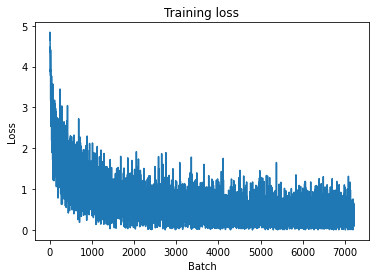

7222it [1:54:26,  1.05it/s]

Loss на обучающей выборке: 0.65332


In [22]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in tqdm(enumerate(train_dataloader)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

Дообучим модель на нескольких итерациях, уменьшив learning rate

In [55]:
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-6)

<All keys matched successfully>

In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set_tune = []
train_loss_tune = 0
best_loss = 0.026659218594431877

# Обучение
# Переводим модель в training mode
model.train()


for step, batch in tqdm(enumerate(train_dataloader)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set_tune.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss_tune += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set_tune)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    print(best_loss)

    if train_loss_tune < best_loss:
      best_loss = train_loss_tune
      torch.save(model.state_dict(), PATH_MODEL_WEIGHTS + str(train_loss_tune) +'.pth')
      print(train_loss_tune)

    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [ ]:
torch.save(model.state_dict(), PATH_MODEL_WEIGHTS + '_0.913.pth')

Загрузим лучшую модель для валидации

In [30]:
# Загрузка модели на GPU
# model.load_state_dict(torch.load(PATH_MODEL_WEIGHTS + '_0.913.pth'))
# Загрузка модели на CPU
model.load_state_dict(torch.load(PATH_MODEL_WEIGHTS + '_0.913.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [30]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in tqdm(validation_dataloader):   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

100%|██████████| 803/803 [03:19<00:00,  4.03it/s]

Процент правильных предсказаний на валидационной выборке: 92.23%


Оценим качество на валидационной выборке

In [32]:
from sklearn.metrics import f1_score

f1_score(valid_labels, valid_preds , average='weighted') , f1_score(valid_labels, valid_preds , average='micro')

(0.9133877376127137, 0.9222680894150634)

Оценим качество модели на Hold-Out датасете:

1. Загрузим лучшую модель

2. Токенизируем отложенную выборку

3. Применим маску

4. Переведем модель в режим оценки и сделаем предикт для выборки

5. Оценим качество модели F1 weighted метрикой

In [31]:
# Загрузка модели на GPU
# model.load_state_dict(torch.load(PATH_MODEL_WEIGHTS + '_0.913.pth'))
# Загрузка модели на CPU
model.load_state_dict(torch.load(PATH_MODEL_WEIGHTS + '_0.913.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

for i, text in enumerate(tokenized_texts):
    text = text[:250]
    text[-1] = '[SEP]'
    tokenized_texts[i] = text


input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=120,
    dtype="long",
    truncating="post",
    padding="post"
)

In [33]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [37]:
model.eval()
test_preds, test_labels = [], []

for batch in tqdm(prediction_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [35]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 91.80%


In [36]:
from sklearn.metrics import f1_score

f1_score(test_labels, test_preds , average='weighted') , f1_score(test_labels, test_preds , average='micro')

(0.9049503321193082, 0.91796875)

In [55]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import itertools

Confusion matrix, without normalization
[[722   0   0   0   0   0   0   0   0   0]
 [  0  15   0   0   0   0   0   0   0   0]
 [  0   0  18   0   0   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   5   0   0]
 [  0   0   1   0   0   0   0   0  13   0]
 [  0   0   0   0   0   0   0   0   0  19]]


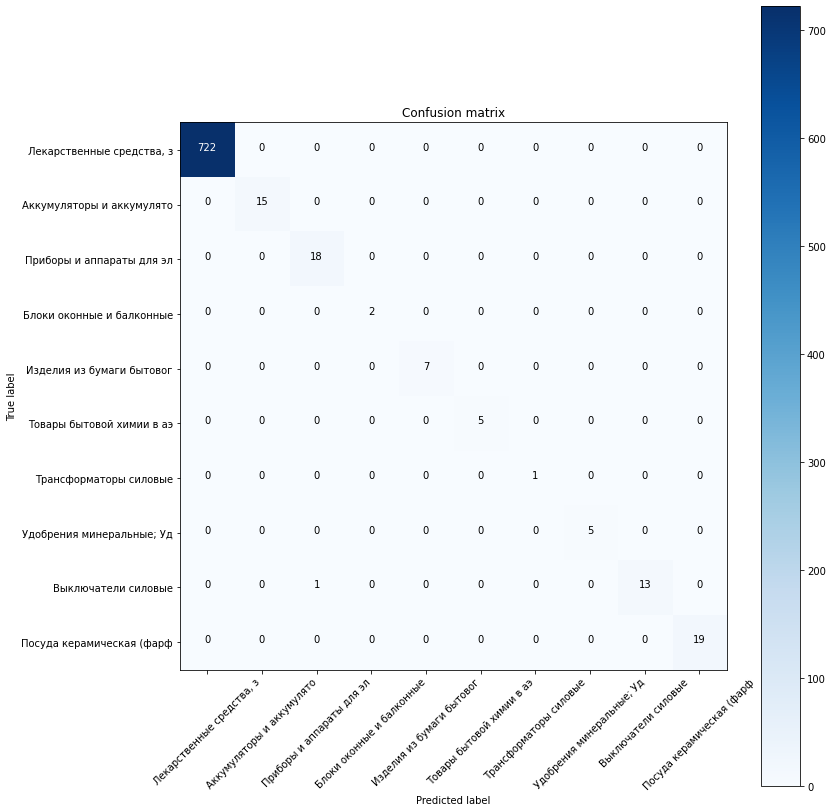

In [154]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(test_labels, test_preds)[:10,:10]
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes=list(target_category_dict.values())[:10],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()